In [1]:
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
from scipy.fftpack import dct
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cross_decomposition import PLSRegression
from statsmodels.tsa.vector_ar.var_model import VAR
from tsaug import TimeWarp, AddNoise, Dropout, Drift, Reverse, Pool

In [3]:
adj_mx_la = pd.read_pickle("./DCRNN/data/sensor_graph/adj_mx_la.pkl")

In [4]:
sensor_list_la = adj_mx_la[0]

In [5]:
train_LA = np.load("./DCRNN/data/METR-LA/train.npz")
test_LA = np.load("./DCRNN/data/METR-LA/test.npz")
val_LA = np.load("./DCRNN/data/METR-LA/val.npz")

In [6]:
print(train_LA["x"].shape, train_LA["y"].shape, train_LA["x_offsets"].shape, train_LA["y_offsets"].shape)
print(test_LA["x"].shape, test_LA["y"].shape, test_LA["x_offsets"].shape, test_LA["y_offsets"].shape)
print(val_LA["x"].shape, val_LA["y"].shape, val_LA["x_offsets"].shape, val_LA["y_offsets"].shape)

(23974, 12, 207, 2) (23974, 12, 207, 2) (12, 1) (12, 1)
(6850, 12, 207, 2) (6850, 12, 207, 2) (12, 1) (12, 1)
(3425, 12, 207, 2) (3425, 12, 207, 2) (12, 1) (12, 1)


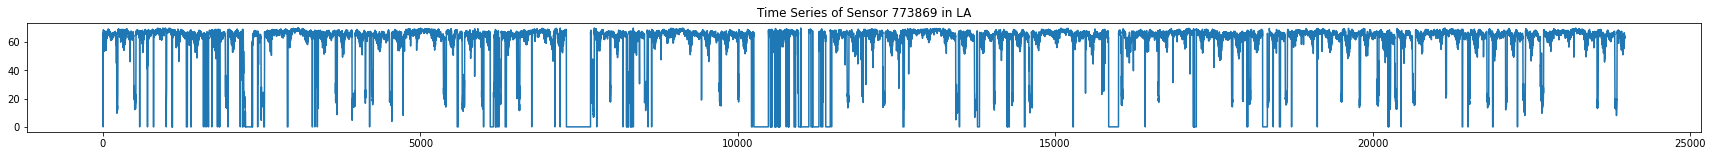

In [7]:
plt.figure(figsize=(30, 2))
plt.plot(train_LA["x"][:, :, 0, 0][:, 0])
plt.title("Time Series of Sensor " + adj_mx_la[0][0] + " in LA")
plt.show()

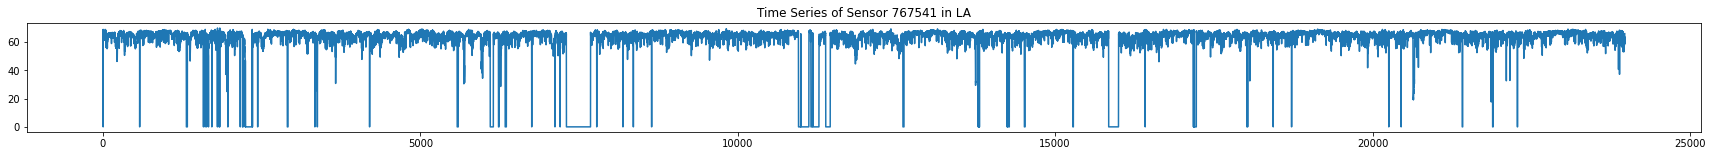

In [8]:
plt.figure(figsize=(30, 2))
plt.plot(train_LA["x"][:, :, 1, 0][:, 0])
plt.title("Time Series of Sensor " + adj_mx_la[0][1] + " in LA")
plt.show()

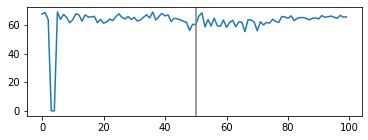

In [9]:
plt.figure(figsize=(6, 2))
timeseries_X = train_LA["x"][:, :, 1, 0][0:50, 0]
timeseries_y = train_LA["x"][:, :, 1, 0][50:100, 0]
plt.plot(np.concatenate([timeseries_X, timeseries_y]))
plt.axvline(x=50, color="grey")
plt.show()

In [50]:
my_augmenter1 = (AddNoise(scale=0.1, distr='gaussian', kind='additive') @ 0.5 * 5)
my_augmenter2 = (TimeWarp() @ 0.5 * 5)
my_augmenter3 = (Reverse() @ 0.5 * 5)
my_augmenter4 = (Drift(max_drift=(0, 0.2)) @ 0.5 * 5)
my_augmenter5 = (Pool(size=3) @ 0.5 * 5)
my_augmenter6 = (Dropout(fill="mean") @ 0.5 * 5)
augmenters = [my_augmenter1, my_augmenter2, my_augmenter3, my_augmenter4, my_augmenter5, my_augmenter6]
augmenter_names = ["Add Noise", "Time Warp", "Reverse", "Drift", "Pool", "Drop"]

In [51]:
results = []
for i in tqdm(range(len(sensor_list_la))):
    # if i > 0:
    #     break
    # print("Sensor: ", sensor_list_la[i])
    test_X = test_LA["x"][:, :, i, 0]
    test_y = test_LA["y"][:, :, i, 0]
    
    HA = np.mean(test_X, axis=1)
    MAE_15_mins, RMSE_15_mins = mean_absolute_error(HA, test_y[:, 2]), np.sqrt(mean_squared_error(HA, test_y[:, 2]))
    MAE_30_mins, RMSE_30_mins = mean_absolute_error(HA, test_y[:, 5]), np.sqrt(mean_squared_error(HA, test_y[:, 5]))
    MAE_60_mins, RMSE_60_mins = mean_absolute_error(HA, test_y[:, 11]), np.sqrt(mean_squared_error(HA, test_y[:, 11]))
    # print(round(MAE_15_mins, 2), round(RMSE_15_mins, 2), round(MAE_30_mins, 2), round(RMSE_30_mins, 2), round(MAE_60_mins, 2), round(RMSE_60_mins, 2))
    results.append([sensor_list_la[i], "HA", MAE_15_mins, RMSE_15_mins, MAE_30_mins, RMSE_30_mins, MAE_60_mins, RMSE_60_mins])
     
    for a, aug in enumerate(augmenters):
        # print(augmenter_names[a])
        test_X_aug = aug.augment(test_X)
        test_y_aug = np.repeat(test_y, 5, axis=0)
        HA_aug = np.mean(test_X_aug, axis=1)
        # print(test_X_aug.shape, test_y_aug.shape, HA_aug.shape)
        MAE_15_mins, RMSE_15_mins = mean_absolute_error(HA_aug, test_y_aug[:, 2]), np.sqrt(mean_squared_error(HA_aug, test_y_aug[:, 2]))
        MAE_30_mins, RMSE_30_mins = mean_absolute_error(HA_aug, test_y_aug[:, 5]), np.sqrt(mean_squared_error(HA_aug, test_y_aug[:, 5]))
        MAE_60_mins, RMSE_60_mins = mean_absolute_error(HA_aug, test_y_aug[:, 11]), np.sqrt(mean_squared_error(HA_aug, test_y_aug[:, 11]))
        # print(round(MAE_15_mins, 2), round(RMSE_15_mins, 2), round(MAE_30_mins, 2), round(RMSE_30_mins, 2), round(MAE_60_mins, 2), round(RMSE_60_mins, 2))
        results.append([sensor_list_la[i], augmenter_names[a], MAE_15_mins, RMSE_15_mins, MAE_30_mins, RMSE_30_mins, MAE_60_mins, RMSE_60_mins])

100%|██████████| 207/207 [06:25<00:00,  1.86s/it]


In [56]:
result_df = pd.DataFrame(results, columns=["Sensor_ID", "Method", "MAE_15mins", "RMSE_15mins", "MAE_30mins", "RMSE_30mins", "MAE_60mins", "RMSE_60mins"])